In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

import split_scale
import env
import model
from wrangle import acquire
from wrangle import clean_data

In [59]:
# acquire data from zillow db
df = acquire('zillow')
df.shape

(14990, 7)

In [60]:
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 7 columns):
bedrooms         14990 non-null float64
bathrooms        14990 non-null float64
sq_feet          14990 non-null float64
property_tax     14989 non-null float64
home_value       14990 non-null float64
property_type    14990 non-null object
fips             14990 non-null float64
dtypes: float64(6), object(1)
memory usage: 819.9+ KB


In [61]:
#check data
df.sample(2)

,bedrooms,bathrooms,sq_feet,property_tax,home_value,property_type,fips
2670,5.0,5.5,5458.0,19452.06,1868000.0,Single Family Residential,6059.0
2494,3.0,2.0,988.0,1821.28,88417.0,Single Family Residential,6037.0


In [62]:
df = clean_data(df)
df.shape

(14989, 7)

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14989 entries, 0 to 14989
Data columns (total 7 columns):
bedrooms         14989 non-null int64
bathrooms        14989 non-null float64
sq_feet          14989 non-null int64
property_tax     14989 non-null float64
home_value       14989 non-null int64
property_type    14989 non-null object
fips             14989 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 936.8+ KB


In [64]:
df['tax_rate'] = df['property_tax']/df['home_value']
df.head()

,bedrooms,bathrooms,sq_feet,property_tax,home_value,property_type,fips,tax_rate
0,3,2.0,1458,2319.90,136104,Single Family Residential,6037,0.017045
1,2,1.0,1421,543.69,35606,Single Family Residential,6037,0.015270
2,4,3.0,2541,9819.72,880456,Single Family Residential,6059,0.011153
3,3,2.0,1650,7673.19,614000,Single Family Residential,6037,0.012497
4,2,1.0,693,3267.47,274237,Single Family Residential,6037,0.011915


In [65]:
fips_dict = {6037: "Los Angeles", 6059: "Orange", 6111: "Ventura"}

df['county_name'] = df['fips'].map(fips_dict)
df.head()
df_county = df[['fips', 'county_name','tax_rate']]
df_county.head()

,fips,county_name,tax_rate
0,6037,Los Angeles,0.017045
1,6037,Los Angeles,0.015270
2,6059,Orange,0.011153
3,6037,Los Angeles,0.012497
4,6037,Los Angeles,0.011915


In [66]:
df_county.groupby('county_name').tax_rate.count()

county_name
Los Angeles    9604
Orange         4094
Ventura        1291
Name: tax_rate, dtype: int64

In [67]:
df_county.groupby('county_name').tax_rate.mean()

county_name
Los Angeles    0.014173
Orange         0.012121
Ventura        0.012054
Name: tax_rate, dtype: float64

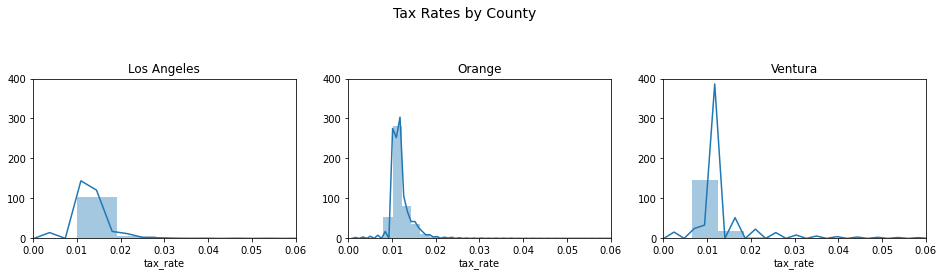

In [99]:
plt.figure(figsize=(16, 10))
plt.suptitle("Tax Rates by County", fontsize=14)
plt.subplot(331)
sns.distplot(df_county[df_county.county_name == "Los Angeles"].tax_rate)
plt.xlim(0, .06)
plt.ylim(0, 400)
plt.title("Los Angeles")
plt.subplot(332)
sns.distplot(df_county[df_county.county_name == "Orange"].tax_rate)
plt.xlim(0, .06)
plt.ylim(0, 400)
plt.title("Orange")
plt.subplot(333)
sns.distplot(df_county[df_county.county_name == "Ventura"].tax_rate)
plt.xlim(0, .06)
plt.ylim(0, 400)
plt.title("Ventura")
plt.show()

In [69]:

train, test = split_scale.split_my_data(df, train_pct=.80, seed=123)
train.head(), test.head()

(       bedrooms  bathrooms  sq_feet  property_tax  home_value  \
 4153          3        2.0     1296       1632.84      122457   
 9185          3        2.0     1909       3605.27      294498   
 6399          4        2.5     1964       1291.02       86907   
 11378         5        3.0     2772       7402.90      559187   
 9935          2        1.0     1015       2252.18      172499   
 
                    property_type  fips  tax_rate  county_name  
 4153   Single Family Residential  6059  0.013334       Orange  
 9185   Single Family Residential  6037  0.012242  Los Angeles  
 6399   Single Family Residential  6059  0.014855       Orange  
 11378  Single Family Residential  6037  0.013239  Los Angeles  
 9935   Single Family Residential  6037  0.013056  Los Angeles  ,
       bedrooms  bathrooms  sq_feet  property_tax  home_value  \
 3144         4        3.0     2774       4309.47      286000   
 6315         4        3.0     2142       8822.75      750000   
 2442         3 

In [70]:
train.shape, test.shape

((11991, 9), (2998, 9))

In [71]:
X_train = train[['bedrooms', 'bathrooms', 'sq_feet']]
y_train = train[['home_value']]
X_test = train[['bedrooms', 'bathrooms', 'sq_feet']]
y_test = train[['home_value']]

In [72]:
scaler, X_train, X_test = split_scale.standard_scaler(X_train, X_test)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [73]:
X_train.head()

,bedrooms,bathrooms,sq_feet
4153,-0.339921,-0.321951,-0.643152
9185,-0.339921,-0.321951,-0.036767
6399,0.725419,0.167093,0.017639
11378,1.790759,0.656137,0.816919
9935,-1.405261,-1.300039,-0.921119


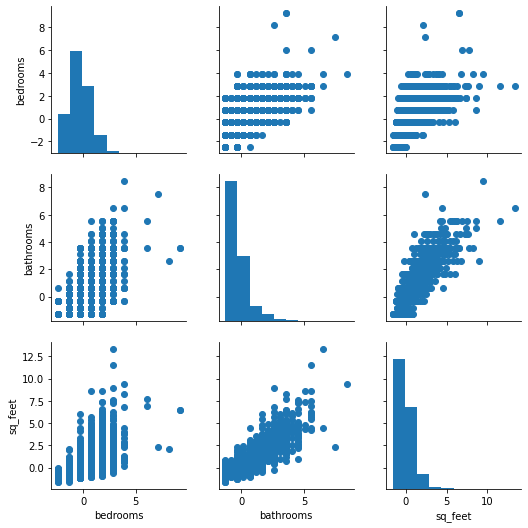

In [74]:
g = sns.PairGrid(X_train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

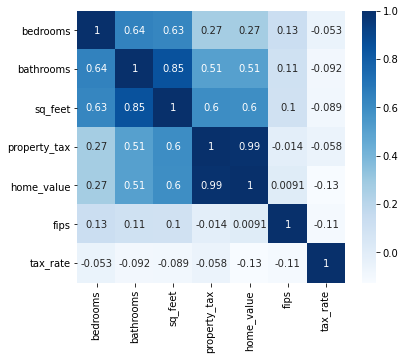

In [75]:
plt.figure(figsize=(6,5))
sns.heatmap(train.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

In [76]:
ols_model = sm.OLS(y_train, X_train).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             home_value   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.246
Method:                 Least Squares   F-statistic:                              1307.
Date:                Mon, 13 Apr 2020   Prob (F-statistic):                        0.00
Time:                        08:10:23   Log-Likelihood:                     -1.8020e+05
No. Observations:               11991   AIC:                                  3.604e+05
Df Residuals:                   11988   BIC:                                  3.604e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bedrooms   -1.427e+05   9920.001    -14.385      0.000   -1.62e+05   -1.23e+05
bathrooms    5.85e+04   1.47e+04      3.970      0.000    2.96e+04    8.74e+04
sq_feet     4.927e+05   1.45e+04     33.935      0.000    4.64e+05    5.21e+05
==============================================================================
Omnibus:                    19941.565   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         35123180.380
Skew:                          10.889   Prob(JB):                         0.00
Kurtosis:                     267.244   Cond. No.                         4.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
predictions = pd.DataFrame({"actual": train.home_value})
predictions.head()

,actual
4153,122457
9185,294498
6399,86907
11378,559187
9935,172499


In [78]:
predictions['baseline'] = train.home_value.mean()
predictions.head()

,actual,baseline
4153,122457,547420.3777
9185,294498,547420.3777
6399,86907,547420.3777
11378,559187,547420.3777
9935,172499,547420.3777


In [79]:
X = X_train

y = y_train

lm = LinearRegression()

lm.fit(X, y)

predictions['simple_lm'] = lm.predict(X)

In [93]:
X = X_train[['bedrooms']]

y = y_train

lm = LinearRegression()

lm.fit(X, y)

predictions['just_bedrooms'] = lm.predict(X)

In [95]:
X = X_train[['bathrooms']]

y = y_train

lm = LinearRegression()

lm.fit(X, y)

predictions['just_bathrooms'] = lm.predict(X)

In [94]:
X = X_train[['sq_feet']]

y = y_train

lm = LinearRegression()

lm.fit(X, y)

predictions['just_area'] = lm.predict(X)

In [80]:
X = X_train
y = y_train

k = 2
lm = LinearRegression()

rfe = RFE(lm, k)
rfe.fit(X, y)
print('selected top 2 features:', X.columns[rfe.support_])

X_rfe = rfe.transform(X)
lm.fit(X_rfe, y)
predictions['multiple_rfe'] = lm.predict(X_rfe)
predictions.head(2)

selected top 2 features: Index(['bedrooms', 'sq_feet'], dtype='object')


,actual,baseline,simple_lm,multiple_rfe
4153,122457,547420.3777,260189.269719,247622.793050
9185,294498,547420.3777,558976.493286,572694.468918


In [89]:
X = X_train
y = y_train

# 1. Generate Polynomial Features
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly.fit(X)
X_poly = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))
X_poly.mean()

bedrooms             -3.010731e-16
bathrooms             1.735748e-16
sq_feet               1.047495e-16
bedrooms bathrooms    6.442735e-01
bedrooms sq_feet      6.304494e-01
bathrooms sq_feet     8.526374e-01
dtype: float64

In [96]:
lm = LinearRegression()
lm.fit(X_poly, y)

predictions['polynomial'] = lm.predict(X_poly)
predictions.head()

,actual,baseline,simple_lm,multiple_rfe,polynomial,just_bedrooms,just_area,just_bathrooms
4153,122457,547420.3777,260189.269719,247622.793050,323349.039190,477520.760127,256298.005792,422926.239366
9185,294498,547420.3777,558976.493286,572694.468918,460740.144847,477520.760127,530777.765606,422926.239366
6399,86907,547420.3777,462369.710992,460876.389872,420301.900549,696591.934805,555404.823990,612033.056286
11378,559187,547420.3777,732788.669883,748371.478736,652202.128260,915663.109483,917198.699895,801139.873206
9935,172499,547420.3777,218030.655487,239593.892086,319122.045808,258449.585449,130476.125682,44712.605526


In [97]:
predictions.apply(lambda c: mean_squared_error(predictions.actual, c))**.5

actual                 0.000000
baseline          760413.949795
simple_lm         601594.364887
multiple_rfe      602316.677613
polynomial        575420.843116
just_bedrooms     732081.712493
just_area         611013.640711
just_bathrooms    654753.904270
dtype: float64

In [98]:
predictions.apply(lambda c: r2_score(predictions.actual, c))

actual            1.000000
baseline          0.000000
simple_lm         0.374097
multiple_rfe      0.372593
polynomial        0.427374
just_bedrooms     0.073130
just_area         0.354343
just_bathrooms    0.258594
dtype: float64

In [ ]:
predictions[]